# Terra em Foco Conference: Introduction to Sentinel Hub APIs in CDSE: Part Two

This notebook was written for a two hour training session at the Terra em Foco, the Portuguese Earth Observation National Conference held in Braga, Portugal 12-13th September 2024.

You will be shown how to:

- Detect forest fires in real time using Sentinel-3 SLSTR imagery.

- Visualise forest fires using Sentinel-2

- Map burn scar extents using Sentinel-2

In [1]:
# General utilities
import getpass
import glob
import tarfile
import warnings
import zipfile
from pathlib import Path
from typing import Any, Optional, Tuple
import seaborn as sns

# Plotting
import folium
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reading satellite imagery
import rasterio as rio
import requests
from matplotlib import colors
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject
from rasterio.features import shapes
from rasterio.features import sieve
from scipy.ndimage import morphology

# Sentinel Hub services
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,    
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    parse_time,
)
from shapely.geometry import shape

warnings.filterwarnings("ignore")
%matplotlib inline

/Users/williamray/miniconda3/envs/sentinelhub_base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In the following cell, we have defined some python functions to help us process and visualise the data later on in the notebook:

In [ ]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])


def vectorize_raster(raster_path, vector_path):
    with rio.open(raster_path) as src:
        raster_data = src.read(1)  # read only the first band
        transform = (
            src.transform
        )  # to convert pixel coordinates to geographic coordinates
        crs = src.crs

    shapes_generator = shapes(
        raster_data, transform=transform
    )  # add mask=raster_data != 0 to exclude nodata values

    vector_data = [
        {"properties": {"value": value}, "geometry": shape}
        for shape, value in shapes_generator
    ]

    gdf = gpd.GeoDataFrame.from_features(vector_data, crs=crs)
    # save to file
    # gdf.to_file(vector_path, driver="GeoJSON")
    return gdf


if __name__ == "__main__":
    vectorize_raster(raster_path, vector_path)

def crop_rasters(filenames, aoi, nodata, output_path, nd=65535):
    """Crop a list of rasters based on a AOI and save the outputs."""
    output_files = []

    for f in filenames:
        with rio.open(f) as raster:
            # Get crs from profile and convert input aoi
            profile = raster.profile
            crop_bound = aoi.to_crs(profile["crs"])

            # Mask raster
            out_img, out_transform = mask(
                raster, shapes=crop_bound, crop=True, nodata=nd
            )

            # Save raster
            output_files.append(f"{output_path}/{Path(f).stem}_crop.tiff")
            write_raster(
                f"{output_path}/{Path(f).stem}_crop.tiff",
                out_img[0, :, :],
                profile["crs"],
                out_transform,
                nd,
                driver="GTiff",
            )

    return output_files


def mosaic_rasters(filenames):
    """Mosaic several rasters."""
    to_mosaic = []
    crs = []
    nodata = []

    for file in filenames:
        src = rio.open(file, masked=True)
        nodata.append(src.nodata)
        to_mosaic.append(src)
        crs.append(src.profile["crs"])

    mosaic, transform = merge(to_mosaic)

    if not all(x == crs[0] for x in crs):
        raise ValueError("Not all files in the same projection!")

    if not all(x == nodata[0] for x in nodata):
        raise ValueError("Not all file have the same nodata mask!")

    return np.where(mosaic == nodata[0], np.nan, mosaic), transform, crs[0]


def rio_resample(method):
    """Return a rasterio resampling method based on a string."""

    resampling_methods = {
        "nearest": rio.enums.Resampling.nearest,
        "bilinear": rio.enums.Resampling.bilinear,
        "cubic": rio.enums.Resampling.cubic,
        "cubic_spline": rio.enums.Resampling.cubic_spline,
        "lanczos": rio.enums.Resampling.lanczos,
        "average": rio.enums.Resampling.average,
        "mode": rio.enums.Resampling.mode,
        "gauss": rio.enums.Resampling.gauss,
        "max": rio.enums.Resampling.max,
        "min": rio.enums.Resampling.min,
        "med": rio.enums.Resampling.med,
        "q1": rio.enums.Resampling.q1,
        "q3": rio.enums.Resampling.q3,
        "sum": rio.enums.Resampling.sum,
        "rms": rio.enums.Resampling.rms,
    }

    if method not in resampling_methods:
        raise ValueError(
            "Wrong resampling method selected."
            " See: https://rasterio.readthedocs.io/en/latest/api/rasterio.enums."
            "html#rasterio.enums.Resampling"
        )

    return resampling_methods[method]


def resample_rasters(filenames, upscale_factor, output_path, method="nearest"):
    """Resample list of rasters."""
    output_files = []

    for file in filenames:
        src = rio.open(file)

        # resample data to target shape
        data = src.read(
            out_shape=(
                src.count,
                int(src.height * upscale_factor),
                int(src.width * upscale_factor),
            ),
            resampling=rio_resample(method),
        )

        # scale image transform
        transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]), (src.height / data.shape[-2])
        )

        # Save rasters
        output_files.append(f"{output_path}/{Path(file).stem}_resampled.tiff")
        write_raster(
            f"{output_path}/{Path(file).stem}_resampled.tiff",
            data[0, :, :],
            src.profile["crs"],
            transform,
            65535,
        )

    return output_files


def reproject_raster(inpath, outpath, crs, method="nearest"):
    "Reproject a raster to a new coordinate system."

    dst_crs = f"EPSG:{crs}"

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {"crs": dst_crs, "transform": transform, "width": width, "height": height}
        )

        with rio.open(outpath, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=rio_resample(method),
                )


def write_raster(path, raster, crs, transform, nodata, driver="GTiff"):
    """Write a raster to a file."""

    with rio.open(
        path,
        "w",
        driver=driver,
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
    ) as dst:
        dst.write(raster, 1)

# define functions to extract statistics for all acquisition dates

def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

## Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials. You can find more detailed instructions on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions for configuring your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions, you can create a profile specifically tailored to use the package to access the Copernicus Data Space Ecosystem data collections. This is useful because changes to the Config class in your notebook are usually only temporary. If you save the configuration in your profile, you do not have to generate new credentials or overwrite/change the default profile every time you start or write a new Jupyter notebook.

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [7]:
# Only run this cell if you have not created a configuration.

# config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
# config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [8]:
config = SHConfig("cdse")

## Example 1: Forest fire detection across northern Portugal utilising Sentinel-3 SLSTR

In [2]:
area_of_interest = "data/aoi3.geojson"

aoi = gpd.read_file(area_of_interest)
aoi_simplified = aoi.geometry.simplify(0.001)
aoi["geometry"] = aoi_simplified
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

In [4]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

### Write an Evalscript

An [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any process, batch processing or OGC request.

In the following Evalscript we will perform all the processing steps that we performed in the "traditional" approach.

In [ ]:
evalscript_true_color = """
// high accuracy Detect active fire points 
//Sentinel-3 SLSTR
//by Tiznger startup co
//www.tiznegar.com

var SAHM= ((S6 - S5) / (S6 + S5));

if(SAHM>.05 && S1<.23){
  return[5*S3, 1*S2, 1*S1]
}

else {
 return [S6,S3,S2]
}

//Red color indicates active fire areas and points
"""

### Build the request

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastRecent` which will return pixels from the least recent acquisition in the specified time period.


In [ ]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_SLSTR.define_from(
                name="s3", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-06", "2023-08-06"),            
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [6]:
true_color_imgs = request_true_color.get_data()

In [8]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 3)


Image type: uint8


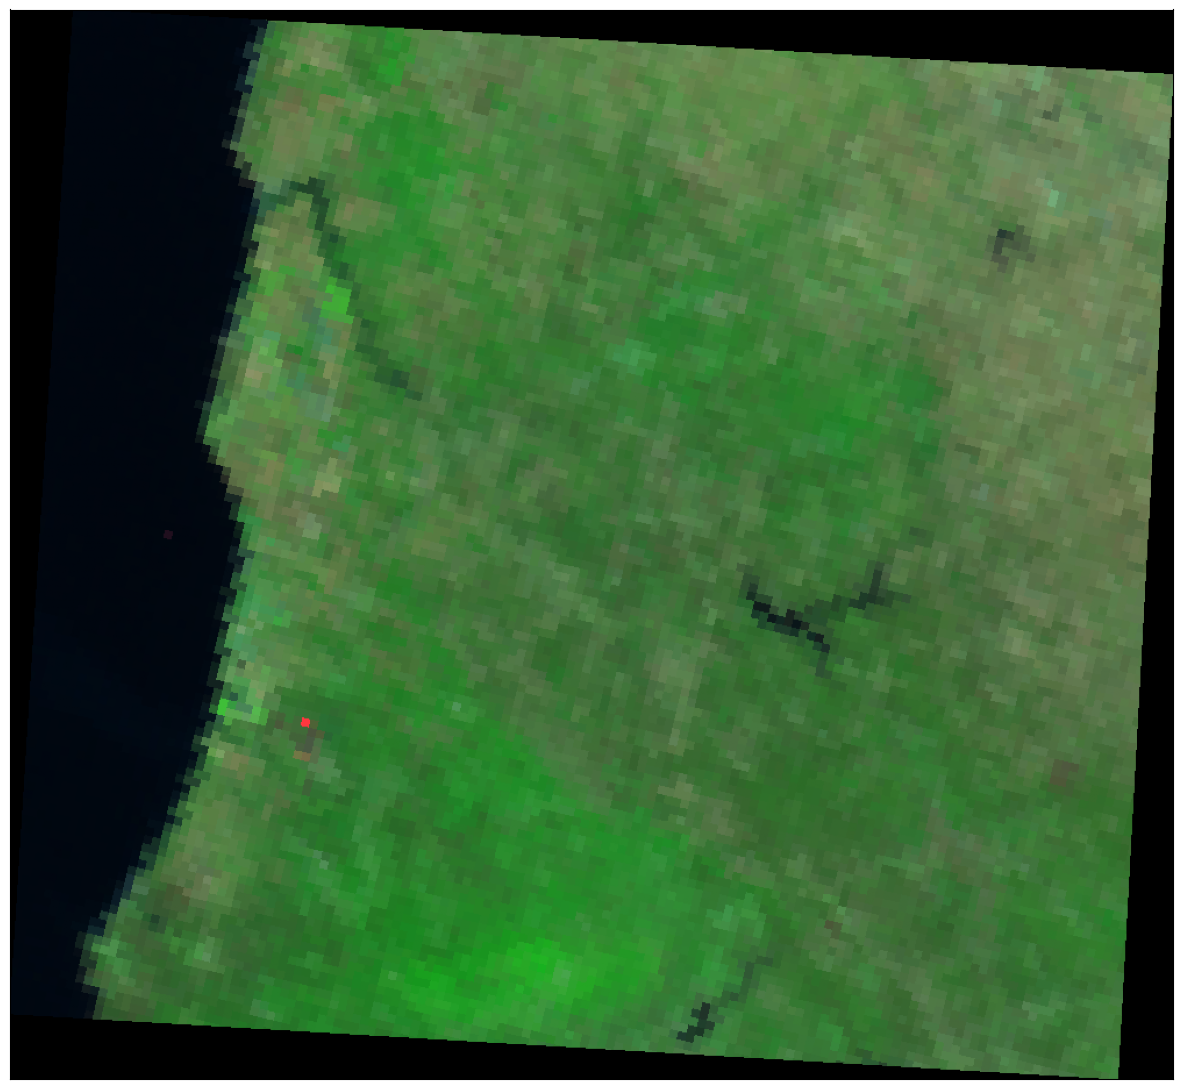

In [9]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor= 1.5 / 255, clip_range=(0, 1))

## Example 2: Visualising forest fires using Sentinel-2 imagery

In [10]:
https://link.dataspace.copernicus.eu/htrw
https://www.reuters.com/world/europe/more-than-1000-evacuated-portugal-wildfire-spreads-2023-08-08/
https://www.theguardian.com/world/2023/aug/08/firefighters-tackling-blaze-raging-in-southern-portugal-fire

SyntaxError: invalid syntax (2485863585.py, line 1)

In [80]:
area_of_interest = "data/aoi5.geojson"

aoi = gpd.read_file(area_of_interest)
aoi_simplified = aoi.geometry.simplify(0.001)
aoi["geometry"] = aoi_simplified
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

In [81]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

In [111]:
evalscript_true_color = """
// VERSION=3
// QuickFire V1.0.0 by Pierre Markuse (https://twitter.com/Pierre_Markuse)
// Adjusted for use in the Copernicus Browser (https://dataspace.copernicus.eu/browser/)
// CC BY 4.0 International (https://creativecommons.org/licenses/by/4.0/)

// Copernicus Browser does not have the band CLP, this was replaced with the isCloud() function
// but do try to turn off cloudAvoidance if results aren't as expected.

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B8A", "B11", "B12", "dataMask"],
        output: { bands: 4 }
    };
}

function isCloud(samples) {
    const NGDR = index(samples.B03, samples.B04);
    const bRatio = (samples.B03 - 0.175) / (0.39 - 0.175);
    return bRatio > 1 || (bRatio > 0 && NGDR > 0);
}

function stretch(val, min, max) { return (val - min) / (max - min); }

function satEnh(arr, s) {
    var avg = arr.reduce((a, b) => a + b, 0) / arr.length;
    return arr.map(a => avg * (1 - s) + a * s);
}

function layerBlend(lay1, lay2, lay3, op1, op2, op3) {
    return lay1.map(function (num, index) {
        return (num / 100 * op1 + (lay2[index] / 100 * op2) + (lay3[index] / 100 * op3));
    });
}

function evaluatePixel(sample) {
    const hsThreshold = [2.0, 1.5, 1.25, 1.0];
    const hotspot = 1;
    const style = 1;
    const hsSensitivity = 1.0;
    const boost = 1.2;

    const cloudAvoidance = 1;
    const avoidanceHelper = 0.8;

    const offset = -0.007;
    const saturation = 1.10;
    const brightness = 1.40;
    const sMin = 0.15;
    const sMax = 0.99;

    const showBurnscars = 0;
    const burnscarThreshold = -0.25;
    const burnscarStrength = 0.3;

    const NDWI = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
    const NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    const waterHighlight = 0;
    const waterBoost = 2.0;
    const NDVI_threshold = 0.05;
    const NDWI_threshold = 0.0;
    const waterHelper = 0.1;

    const Black = [0, 0, 0];
    const NBRindex = (sample.B08 - sample.B12) / (sample.B08 + sample.B12);
    const naturalColorsCC = [Math.sqrt(brightness * sample.B04 + offset), Math.sqrt(brightness * sample.B03 + offset), Math.sqrt(brightness * sample.B02 + offset)];
    const naturalColors = [(2.5 * brightness * sample.B04 + offset), (2.5 * brightness * sample.B03 + offset), (2.5 * brightness * sample.B02 + offset)];
    const URBAN = [Math.sqrt(brightness * sample.B12 * 1.2 + offset), Math.sqrt(brightness * sample.B11 * 1.4 + offset), Math.sqrt(brightness * sample.B04 + offset)];
    const SWIR = [Math.sqrt(brightness * sample.B12 + offset), Math.sqrt(brightness * sample.B8A + offset), Math.sqrt(brightness * sample.B04 + offset)];
    const NIRblue = colorBlend(sample.B08, [0, 0.25, 1], [[0 / 255, 0 / 255, 0 / 255], [0 / 255, 100 / 255, 175 / 255], [150 / 255, 230 / 255, 255 / 255]]);
    const classicFalse = [sample.B08 * brightness, sample.B04 * brightness, sample.B03 * brightness];
    const NIR = [sample.B08 * brightness, sample.B08 * brightness, sample.B08 * brightness];
    const atmoPen = [sample.B12 * brightness, sample.B11 * brightness, sample.B08 * brightness];
    var enhNaturalColors = [0, 0, 0];
    for (let i = 0; i < 3; i += 1) { enhNaturalColors[i] = (brightness * ((naturalColors[i] + naturalColorsCC[i]) / 2) + (URBAN[i] / 10)); }

    const manualCorrection = [0.04, 0.00, -0.05];

    var Viz = layerBlend(URBAN, SWIR, naturalColorsCC, 10, 10, 90); // Choose visualization(s) and opacity here

    if (waterHighlight) {
        if ((NDVI < NDVI_threshold) && (NDWI > NDWI_threshold) && (sample.B04 < waterHelper)) {
            Viz[1] = Viz[1] * 1.2 * waterBoost + 0.1;
            Viz[2] = Viz[2] * 1.5 * waterBoost + 0.2;
        }
    }

    Viz = satEnh(Viz, saturation);
    for (let i = 0; i < 3; i += 1) {
        Viz[i] = stretch(Viz[i], sMin, sMax);
        Viz[i] += manualCorrection[i];
    }

    if (hotspot) {
        if ((!cloudAvoidance) || (!isCloud(sample) && (sample.B02 < avoidanceHelper))) {
            switch (style) {
                case 1:
                    if ((sample.B12 + sample.B11) > (hsThreshold[0] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.50 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[1] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.20 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[2] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.10 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.00 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    break;
                case 2:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 0, 0, sample.dataMask];
                    break;
                case 3:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 1, 0, sample.dataMask];
                    break;
                case 4:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [Viz[0] + 0.2, Viz[1] - 0.2, Viz[2] - 0.2, sample.dataMask];
                    break;
                default:
            }
        }
    }

    if (showBurnscars) {
        if (NBRindex < burnscarThreshold) {
            Viz[0] = Viz[0] + burnscarStrength;
            Viz[1] = Viz[1] + burnscarStrength;
        }
    }

    return [Viz[0], Viz[1], Viz[2], sample.dataMask];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-07", "2023-08-07"),            
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [112]:
true_color_imgs = request_true_color.get_data()

In [113]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 4)


Image type: uint8


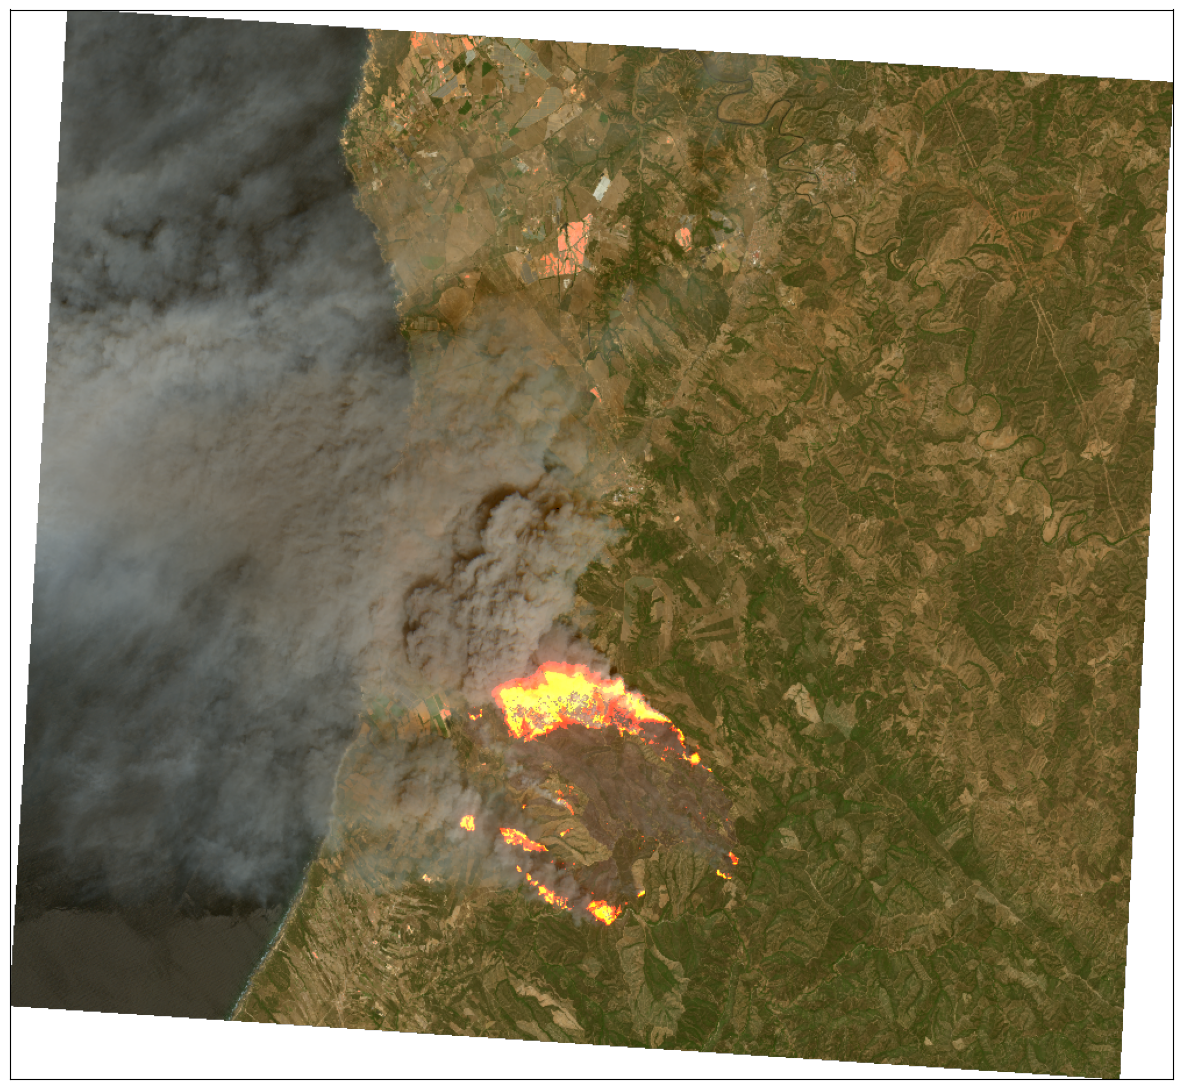

In [114]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor= 1 / 255, clip_range=(0, 1))

## Example 3: Mapping and measuring the area of burn scars

In [12]:
area_of_interest = "data/aoi4.geojson"

aoi = gpd.read_file(area_of_interest)
aoi_simplified = aoi.geometry.simplify(0.001)
aoi["geometry"] = aoi_simplified
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

In [13]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

In [99]:
evalscript_true_color = """
//VERSION=3
// Burneed area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: { bands: 4 }
      };
}

function evaluatePixel(samples) {
	var NDWI=index(samples.B03, samples.B08); 
	var NDVI=index(samples.B08, samples.B04);
	var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

  	if((INDEX>0.2)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
  		return[2.5*samples.B04, 2.5*samples.B03, 2.5*samples.B02, samples.dataMask]
	}
	else {
 	return [1, 0, 0, samples.dataMask]
	}
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-10", "2023-08-15"),            
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [100]:
true_color_imgs = request_true_color.get_data()

In [101]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 4)


Image type: uint8


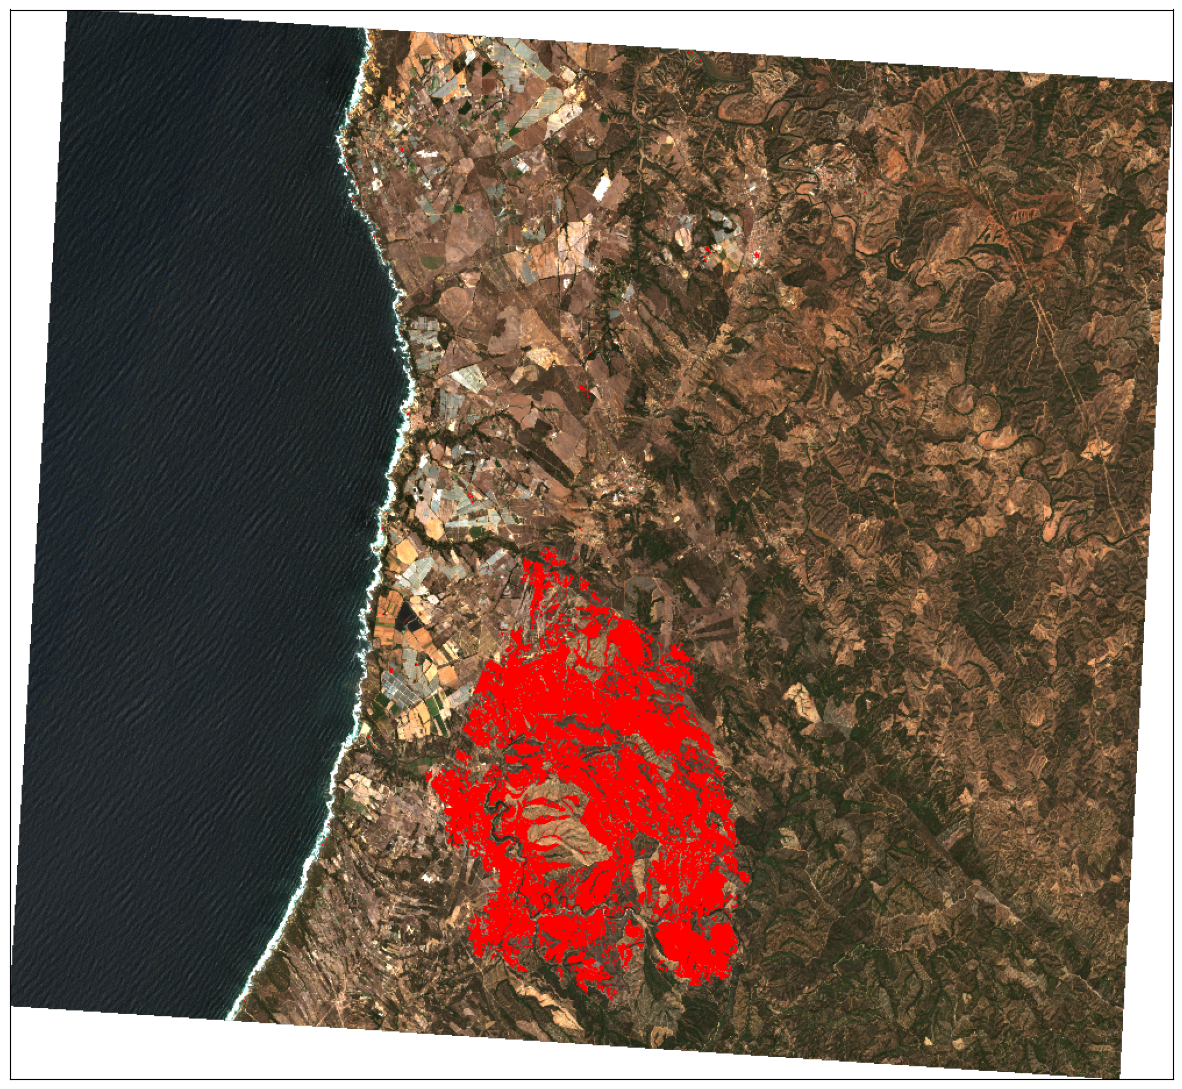

In [102]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor= 1.5 / 255, clip_range=(0, 1))